In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")

In [3]:
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node
# from game_environments.play_chess.playchess import PlayChess
from game_environments.gamenode import GameNode
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
from neural_networks.breakthrough.breakthrough_nn import BreakthroughNN

import torch

import numpy as np
from tqdm import tqdm

GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}

selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

CUDA = torch.cuda.is_available()

def selfplay(first_network_path, first_network_name, second_network_path, second_network_name, state_example):

    neural_network_1 = BreakthroughNN(state_example.cols, state_example.rows, state_example.get_move_amount())
    neural_network_2 = BreakthroughNN(state_example.cols, state_example.rows, state_example.get_move_amount())

    test_as_white = True

    if test_as_white:
        neural_network_1.loadmodel(first_network_path, first_network_name)
        neural_network_2.loadmodel(second_network_path, second_network_name)
    else:
        neural_network_2.loadmodel(first_network_path, first_network_name)
        neural_network_1.loadmodel(second_network_path, second_network_name)

    memo_nn1 = {}
    memo_nn2 = {}

    NN_THINK = 100

    initial_node = Node(state_example.initial_state(), "START")
    first_win = 0
    second_win = 0
    total_games = 0
    for _ in range(100):
        curr_node = initial_node
        monte_tree_1 = MCTS()
        monte_tree_2 = MCTS()
        total_games += 1
        while True:

            if not curr_node.is_expanded():
                curr_node.expand()
            pi,v = neural_network_1.safe_predict(curr_node.gamestate)
            if CUDA:
                pi = pi.detach().cpu().numpy() 
                pi = pi.reshape(-1)
            else:
                pi = pi.view(-1)

            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi).item()
            curr_node = np.random.choice(curr_node.children, p=pi)

            if curr_node.gamestate.is_terminal():
                if curr_node.gamestate.reward() == 1:
                    first_win += 1
                break

            if not curr_node.is_expanded():
                    curr_node.expand()

            pi,v = neural_network_2.safe_predict(curr_node.gamestate)
            if CUDA:
                pi = pi.detach().cpu().numpy() 
                pi = pi.reshape(-1)
            else:
                pi = pi.view(-1)

            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi).item()

            curr_node = np.random.choice(curr_node.children, p=pi)

            if curr_node.gamestate.is_terminal():
                if curr_node.gamestate.reward() == -1:
                    second_win += 1
                break
    if test_as_white:
        winrate = first_win/total_games
    else:
        winrate = second_win/total_games
    return winrate
    

network_path = "./trained_models"
percentage = []
for i in tqdm(range(0,31)):
    percentage.append(selfplay(network_path,f"session2_res5_gen{i*10}.tar", network_path, f"session2_res5_gen150.tar",initial_state))
print(percentage)
import matplotlib.patches as mpatches
gens = [10*k for k in range(0,31)]

fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1))
plt.plot(ticks,percentage, "b")
trendline1 = np.polyfit(ticks, percentage, 3)
p1 = np.poly1d(trendline1)
plt.plot(ticks,p1(ticks), '--', color="forestgreen")
patches = []
patches.append(mpatches.Patch(color='b', label='Winrate vs Neural Network (generation 150)'))
plt.legend(handles=patches)
plt.margins(0,0.5)
plt.show()

 16%|█▌        | 5/31 [00:30<02:36,  6.03s/it]


KeyboardInterrupt: 

100%|██████████| 31/31 [23:39<00:00, 45.80s/it]

[0.0, 0.36, 0.64, 0.56, 0.68, 0.28, 0.88, 0.64, 0.52, 0.4, 0.28, 0.48, 0.48, 0.64, 0.64, 0.88, 0.72, 0.84, 0.88, 0.84, 0.72, 0.84, 0.68, 0.64, 0.6, 0.6, 0.56, 0.8, 0.68, 0.56, 0.8]


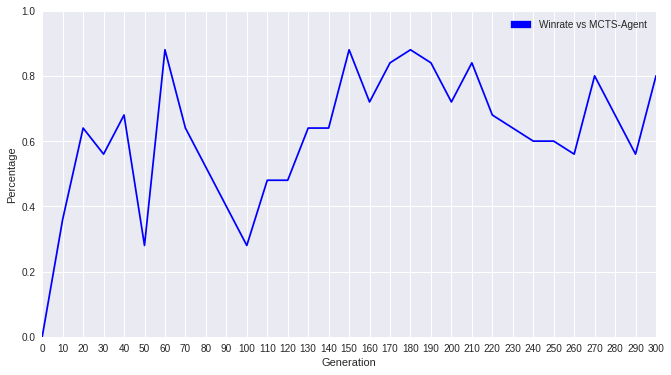

In [9]:
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node
# from game_environments.play_chess.playchess import PlayChess
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
from pprint import pprint
from collections import namedtuple
import numpy as np
from tqdm import tqdm
import json
from datetime import time


GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}

selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

def play_game(first_network_path, first_network_name, n_simulations=50):
    """
    Function that plays a game between two players
    using monte carlo tree search, white_think and
    black_think reference the amount of mcts rollout
    each player does
    """
    black_think = 100

    whiteplayer = MCTS()
    blackplayer = MCTS()
    blackplayer.temp = 0.99
    
    neural_network = BreakthroughNN(initial_state.cols, initial_state.rows, initial_state.get_move_amount())
    
    neural_network.loadmodel(first_network_path, first_network_name)
    
    
    first_win = 0
    second_win = 0

    for _ in range(n_simulations):
        curr_node = Node(selected_game.initial_state(), "START")
        while True:
            if not curr_node.is_expanded():
                curr_node.expand()
            pi,v = neural_network.safe_predict(curr_node.gamestate)
            if CUDA:
                pi = pi.detach().cpu().numpy() 
                pi = pi.reshape(-1)
            else:
                pi = pi.view(-1)

            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi).item()
            curr_node = np.random.choice(curr_node.children, p=pi)

            if curr_node.gamestate.is_terminal():
                first_win += 1
                break
                
            for _ in range(black_think):
                blackplayer.rollout(curr_node)
            curr_node = blackplayer.get_best_child(curr_node)

            if curr_node.gamestate.is_terminal():
                second_win += 1
                break

    winrate = first_win/n_simulations
    return winrate


network_path = "./trained_models"
percentage = []
for i in tqdm(range(0,31)):
    percentage.append(play_game(network_path,f"session2_res5_gen{i*10}.tar",25))
print(percentage)
# percentage = [0.08, 0.6, 0.56, 0.6, 0.64, 0.72, 0.88, 0.48, 0.64, 0.32, 0.44, 0.44, 0.72, 0.68, 0.64, 0.64, 0.68, 0.6, 0.68, 0.72, 0.84, 0.88, 0.68, 0.72, 0.68, 0.72, 0.76, 0.8, 0.68, 0.52, 0.76]
import matplotlib.patches as mpatches
gens = [10*k for k in range(0,31)]

fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1))
plt.plot(ticks,percentage, "b")
# trendline1 = np.polyfit(ticks, percentage, 3)
# p1 = np.poly1d(trendline1)
# plt.plot(ticks,p1(ticks), '--', color="forestgreen")
patches = []
patches.append(mpatches.Patch(color='b', label='Winrate vs MCTS-Agent'))
plt.legend(handles=patches)
plt.margins(0,0.5)
plt.show()


In [ ]:
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node
# from game_environments.play_chess.playchess import PlayChess
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
from neural_networks.breakthrough.breakthrough_nn import BreakthroughNN
from pprint import pprint
from collections import namedtuple
import json
from datetime import time
import torch
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm


GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}

CUDA = torch.cuda.is_available()

selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

def play_game(first_network_path, first_network_name, n_simulations=50):
    """
    Function that plays a game between two players
    using monte carlo tree search, white_think and
    black_think reference the amount of mcts rollout
    each player does
    """
    black_think = 100

    whiteplayer = MCTS()
    neural_network = BreakthroughNN(initial_state.cols, initial_state.rows, initial_state.get_move_amount())
    neural_network.loadmodel(first_network_path, first_network_name)
    
    first_win = 0
    second_win = 0

    for _ in range(n_simulations):
        curr_node = Node(selected_game.initial_state(), "START")
        while True:
            if not curr_node.is_expanded():
                curr_node.expand()
            pi,v = neural_network.safe_predict(curr_node.gamestate)
            if CUDA:
                pi = pi.detach().cpu().numpy() 
                pi = pi.reshape(-1)
            else:
                pi = pi.view(-1)

            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi).item()
            
            curr_node = np.random.choice(curr_node.children,p=pi)

            if curr_node.gamestate.is_terminal():
                first_win += 1
                break
                
            if not curr_node.is_expanded():
                curr_node.expand()
                
            pickable = [child for child in curr_node.children if child]
                
            curr_node = np.random.choice(pickable)

            if curr_node.gamestate.is_terminal():
                second_win += 1
                break
    winrate = first_win/n_simulations
    return winrate


results_start = {
    "black": 0,
    "white": 0,
}

whitewins = 0
blackwins = 0

network_path = "./trained_models"
percentage = []
for i in tqdm(range(0,31)):
    percentage.append(play_game(network_path,f"session2_res5_gen{i*10}.tar",25))
print(percentage)
import matplotlib.patches as mpatches
gens = [10*k for k in range(0,31)]

fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1))
plt.plot(ticks,percentage, "b")
trendline1 = np.polyfit(ticks, percentage, 3)
p1 = np.poly1d(trendline1)
plt.plot(ticks,p1(ticks), '--', color="forestgreen")
patches = []
patches.append(mpatches.Patch(color='b', label='Winrate vs '))
plt.legend(handles=patches)
plt.margins(0,0.5)
plt.show()


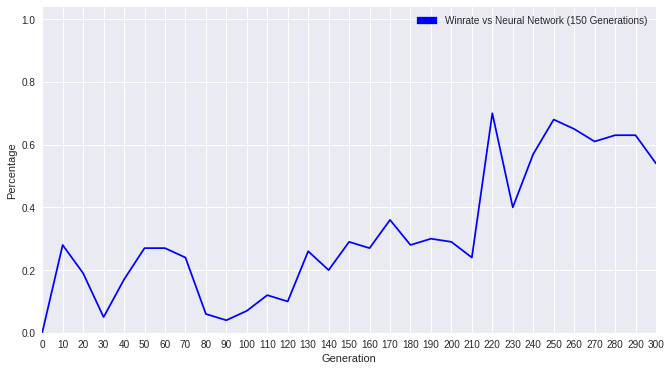

In [43]:
gens = [10*k for k in range(0,31)]

fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1.04))
plt.plot(ticks,percentage, "b")
# trendline1 = np.polyfit(ticks, percentage, 1)
# p1 = np.poly1d(trendline1)
# plt.plot(ticks,p1(ticks), '--', color="forestgreen")
patches = []
patches.append(mpatches.Patch(color='b', label='Winrate vs Neural Network (150 Generations)'))
plt.legend(handles=patches)
plt.margins(0,0.)
plt.show()
